# Active Learning Tutorial

This notebook showcases different active learning query strategies (Uncertainty Sampling and Query-By-Committee) and its evaluation. 

In [1]:
import numpy as np
import math
import pandas as pd
from numpy.random import choice

# for general active learning algorithm
from modAL.models import ActiveLearner, Committee
# uncertainity measures and uncertainity based sampling strategies
from modAL.uncertainty import uncertainty_sampling, margin_sampling, entropy_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

## 1. What is Active Learning?
Active learning is a machine learning paradigm where the model learns from user interaction. The model is trained on a subset of the data and the user is asked to label the most useful datapoint. The model is then retrained on the new labelled data and the process is repeated until the model converges.

### 1.1 Classification with Active Learning
First, we use modAL library (built on top of Scikit) to look at a classification task using active learning. Several sampling strategies are showcased in this example to select the most useful datapoint to be labelled by an expert. There are several ways to estimate the usefulness. For example, one possible way of estimating is by using the classification uncertainty: 

$$
U(x) = 1 - P(\hat{x} | x)
$$

where $\hat{x}$ is the predicted class and $x$ is the input datapoint. **The higher the uncertainty, the more useful the datapoint is to be labelled.**


### Load movies and ratings dataset

In [2]:
df_movies = pd.read_csv('./data/movies.csv')
print(df_movies.shape, df_movies.columns)
df_movies.head()

(9742, 3) Index(['movieId', 'title', 'genres'], dtype='object')


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
df_ratings = pd.read_csv('./data/ratings.csv')
print(df_ratings.shape, df_ratings.columns)
df_ratings.head()

(100836, 4) Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Preprocess the datasets to do some learning task

One-hot encoding for categorical features (genres)

In [4]:
genre_list = set()
for genres in df_movies['genres']:
    genre_list.update(genres.split('|'))
genre_list.remove('(no genres listed)')
genre_list = list(genre_list)

print(genre_list)

['Sci-Fi', 'Horror', 'War', 'Film-Noir', 'Children', 'Animation', 'Thriller', 'Western', 'IMAX', 'Action', 'Mystery', 'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Crime', 'Musical', 'Romance', 'Documentary']


In [5]:
for genre in genre_list:
    df_movies[genre] = 0

for i, row in df_movies.iterrows():
    for genre in row['genres'].split('|'):
        if genre == '(no genres listed)':
            continue
        df_movies.at[i, genre] = 1

df_movies.drop(['genres'], axis=1, inplace=True)
df_movies.head()


,movieId,title,Sci-Fi,Horror,War,Film-Noir,Children,Animation,Thriller,Western,...,Action,Mystery,Adventure,Comedy,Drama,Fantasy,Crime,Musical,Romance,Documentary
0,1,Toy Story (1995),0,0,0,0,1,1,0,0,...,0,0,1,1,0,1,0,0,0,0
1,2,Jumanji (1995),0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Convert the ratings from float to int

In [6]:
df_ratings['rating'] = df_ratings['rating'].apply(lambda x: math.ceil(x))
print(np.unique(df_ratings['rating']))
df_ratings

[1 2 3 4 5]


,userId,movieId,rating,timestamp
0,1,1,4,964982703
1,1,3,4,964981247
2,1,6,4,964982224
3,1,47,5,964983815
4,1,50,5,964982931
...,...,...,...,...
100831,610,166534,4,1493848402
100832,610,168248,5,1493850091
100833,610,168250,5,1494273047
100834,610,168252,5,1493846352


In [7]:
df_movies.columns

Index(['movieId', 'title', 'Sci-Fi', 'Horror', 'War', 'Film-Noir', 'Children',
       'Animation', 'Thriller', 'Western', 'IMAX', 'Action', 'Mystery',
       'Adventure', 'Comedy', 'Drama', 'Fantasy', 'Crime', 'Musical',
       'Romance', 'Documentary'],
      dtype='object')

In [8]:
df = pd.merge(df_movies, df_ratings, on='movieId')
df.index = range(df.shape[0])
print(df.shape)
df.head()

(100836, 24)


,movieId,title,Sci-Fi,Horror,War,Film-Noir,Children,Animation,Thriller,Western,...,Comedy,Drama,Fantasy,Crime,Musical,Romance,Documentary,userId,rating,timestamp
0,1,Toy Story (1995),0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,1,4,964982703
1,1,Toy Story (1995),0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,5,4,847434962
2,1,Toy Story (1995),0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,7,5,1106635946
3,1,Toy Story (1995),0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,15,3,1510577970
4,1,Toy Story (1995),0,0,0,0,1,1,0,0,...,1,0,1,0,0,0,0,17,5,1305696483


In [9]:
X = df.loc[:, df.columns != 'rating'].copy()
X.drop(['title'], axis=1, inplace=True)
X.head()

,movieId,Sci-Fi,Horror,War,Film-Noir,Children,Animation,Thriller,Western,IMAX,...,Adventure,Comedy,Drama,Fantasy,Crime,Musical,Romance,Documentary,userId,timestamp
0,1,0,0,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,1,964982703
1,1,0,0,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,5,847434962
2,1,0,0,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,7,1106635946
3,1,0,0,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,15,1510577970
4,1,0,0,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,17,1305696483


In [10]:
y = df['rating'].copy()
y.head()

0    4
1    4
2    5
3    3
4    5
Name: rating, dtype: int64

In [11]:
cols = X.columns
X = X.to_numpy()
y = y.to_numpy()

### Training

#### Split the data set to train/test for classification

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

In [13]:
n_initial, n_queries = 1000, 15

take a random smaller portion of the training dataset to initially train the classifier

In [14]:
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)
print(X_initial.shape, X_pool.shape)

(1000, 22) (79668, 22)


#### Uncertainty sampling

When you present unlabelled examples to an active learner, it finds you the most useful example and presents it for you to be labelled. 
This is done by first calculating the usefulness of prediction (whatever it means) for each example and select an instance based on the usefulness. 
The thing is, there are several ways to measure this. They are based upon the classification uncertainty, hence they are called uncertainty measures. 
In modAL, currently you can select from three built-in measures: classification uncertainty, classification margin and classification entropy.


- **Classification uncertainty**: The simplest measure is the uncertainty of classification defined by $U(x)=1-P(\hat{x}|x)$ where $x$ is the instance to be predicted and $\hat{x}$ is the most likely prediction.

- **Classification margin**: Classification margin is the difference in probability of the first and second most likely prediction, that is, it is defined by $M(x)=P(\hat{x_1}|x)-P(\hat{x_2}|x)$ where $\hat{x_1}$ and $\hat{x_2}$ are the first and second most likely classes.

- **Classification entropy**: The third built-in uncertainty measure is the classification entropy, which is defined by $H(x)=-\sum_{k}p_k\log(p_k)$ where $p_k$ is the probability of the sample belonging to the $k$-th class. Heuristically, the entropy is proportional to the average number of guesses one has to make to find the true class.


_Source: <https://modal-python.readthedocs.io/en/latest/content/query_strategies/uncertainty_sampling.html>_


In [15]:
query_strategies = [uncertainty_sampling, margin_sampling, entropy_sampling]

solo_learners = []

for query_strategy in query_strategies:
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_initial, y_training=y_initial,
        query_strategy=query_strategy
    )
    solo_learners.append(learner)

An example probability matrix:
    
[[0.1 , 0.85, 0.05],

[0.6 , 0.3 , 0.1 ],
                  
[0.39, 0.61, 0.0 ]]

Which sample will be presented to expert for each of the three above query strategies?

#### Initializing Committee members

One of the popular active learning strategies is the Query by Committee, where we keep several hypotheses (i.e. trained classifiers) about the data, and we select our queries by **measuring the disagreement** of the hypotheses. In modAL, this model is implemented in the Committee class.

#### Query by Committee



Query by Committee is another popular active learning strategy, which alleviates many disadvantages of uncertainty sampling. For instance, uncertainty sampling tends to be biased towards the actual learner and it may miss important examples which are not in the sight of the estimator. This is fixed by keeping several hypotheses at the same time, selecting queries where disagreement occurs between them. 

_Source: <https://modal-python.readthedocs.io/en/latest/content/models/Committee.html> & <https://modal-python.readthedocs.io/en/latest/content/examples/query_by_committee.html>_


In [16]:
n_members = 3
learner_list = list()
xp, yp = X_pool, y_pool

for member_idx in range(n_members):
    # give each member a different random seed
    train_idx = np.random.choice(range(xp.shape[0]), size=n_initial, replace=False)
    X_train = xp[train_idx]
    y_train = yp[train_idx]

    # creating a reduced copy of the data with the known instances removed
    xp = np.delete(xp, train_idx, axis=0)
    yp = np.delete(yp, train_idx)

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train
    )
    learner_list.append(learner)

# assembling the committee
committee = Committee(learner_list=learner_list)

#### Evaluate the classifier accuracy on the test dataset

**assuming the oracle is accurate!**

In [17]:
accuracy_scores = [(1, solo_learners[0].score(X_test, y_test))]
accuracy_scores.append((2, solo_learners[1].score(X_test, y_test)))
accuracy_scores.append((3, solo_learners[2].score(X_test, y_test)))
accuracy_scores.append((4, committee.score(X_test, y_test)))
print(accuracy_scores)

[(1, 0.36944664815549383), (2, 0.37559500198333995), (3, 0.3730662435541452), (4, 0.4098571995239984)]


#### apply the strategies to select datapoints (pool-based) to be labelled and evaluate the classifier

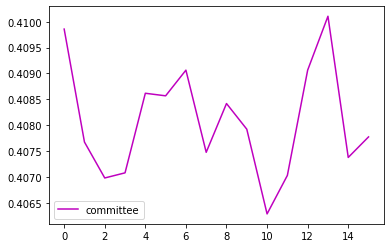

Thank you for your inputs!


In [18]:
# initializing learners and their names
learners = solo_learners + [committee]
learner_names = ['solo uncertainty sampling', 'solo margin sampling', 'solo entropy sampling', 'committee']
colors = ['r', 'g', 'b', 'm']

for i in range(len(learners)):
    # copy the pool to avoid removing the same instances from all learners
    xp, yp = X_pool, y_pool
    
    for j in range(n_queries):
        # query the learner for the next instance
        query_idx, query_inst = learners[i].query(xp)

        # get the rating for movie and user combination
        rating = int(df[(df['movieId'] == query_inst[0][0]) & (df['userId'] == query_inst[0][-2])]['rating'].values[0])
        y_new = np.array([rating], dtype=int)

        # teach our ActiveLearner model the record it has requested
        learners[i].teach(query_inst.reshape(1, -1), y_new)
        
        # creating a reduced copy of the data with the known instances removed
        xp, yp = np.delete(xp, query_idx, axis=0), np.delete(yp, query_idx, axis=0)

        # calculate and report our model's accuracy
        accuracy_scores.append((i + 1, learners[i].score(X_test, y_test)))
        display.clear_output(wait=True)
        plt.plot([score[1] for score in accuracy_scores if score[0] == i + 1], label=learner_names[i], color=colors[i])
        plt.legend()
        plt.show()

print("Thank you for your inputs!")

#### assuming the oracle is with a 20% margin of error

In [19]:
eaccuracy_scores = [(1, solo_learners[0].score(X_test, y_test))]
eaccuracy_scores.append((2, solo_learners[1].score(X_test, y_test)))
eaccuracy_scores.append((3, solo_learners[2].score(X_test, y_test)))
eaccuracy_scores.append((4, committee.score(X_test, y_test)))

#### apply the strategies to select datapoints (pool-based) to be labelled and evaluate the classifier with a 20% margin of error

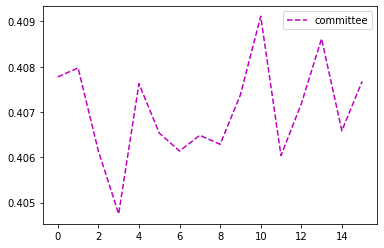

Thank you for your inputs!


In [20]:
for i in range(len(learners)):
    # copy the pool to avoid removing the same instances from all learners
    xp, yp = X_pool, y_pool
    for j in range(n_queries):
        # query the learner for the next instance
        query_idx, query_inst = learners[i].query(xp)
        
        # get the rating for movie and user combination and add 20% noise
        error = choice([0, 1], 1, p=[0.8, 0.2])[0]
        true_rating = int(df[(df['movieId'] == query_inst[0][0]) & (df['userId'] == query_inst[0][-2])]['rating'].values[0])
        if error:
            # take a random rating except the true one
            ratingList = [1, 2, 3, 4, 5]
            ratingList.remove(true_rating)
            rating = choice(ratingList, 1)[0]
        else:
            # take the true rating
            rating = true_rating
        y_new = np.array([rating], dtype=int) #labeled instance

        # teach our ActiveLearner model the record it has requested
        learners[i].teach(query_inst.reshape(1, -1), y_new)

        # creating a reduced copy of the data with the known instances removed
        xp, yp = np.delete(xp, query_idx, axis=0), np.delete(yp, query_idx, axis=0)
        
        # calculate and report our model's accuracy
        eaccuracy_scores.append((i + 1, learners[i].score(X_test, y_test)))
        display.clear_output(wait=True)
        plt.plot([score[1] for score in eaccuracy_scores if score[0] == i + 1], label=learner_names[i], color=colors[i], linestyle='dashed', linewidth=1.5)
        plt.legend()
        plt.show()

print("Thank you for your inputs!")

#### plot the accuracy over active learning results

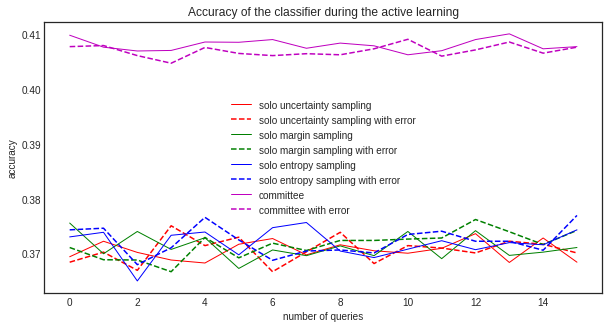

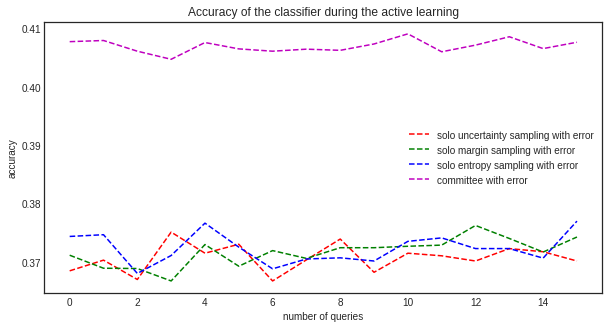

In [21]:
def plot(show_original=True, show_error=True):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        plt.title('Accuracy of the classifier during the active learning')
        for i in range(len(learners)):
            if show_original:
                scores = [each[1] for each in accuracy_scores if each[0] == i + 1]
                plt.plot(range(n_queries + 1), scores, linewidth=1, color=colors[i], label=learner_names[i])
            if show_error:
                scores = [each[1] for each in eaccuracy_scores if each[0] == i + 1]
                plt.plot(range(n_queries + 1), scores, linestyle='--', linewidth=1.5, color=colors[i],
                        label=learner_names[i] + ' with error')
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        plt.legend()
        plt.show()
plot()
plot(show_original=False)

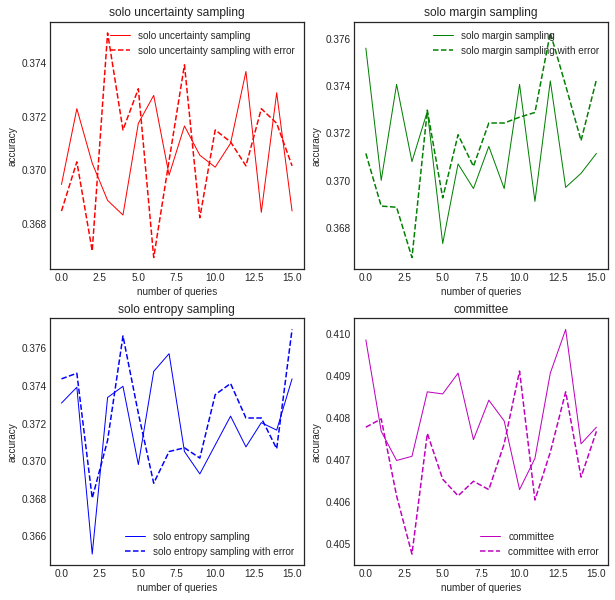

In [22]:
with plt.style.context('seaborn-white'):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i in range(len(learners)):
        current_ax = ax[i // 2][i % 2]
        scores = [each[1] for each in accuracy_scores if each[0] == i + 1]
        current_ax.plot(range(n_queries + 1), scores, linewidth=1, color=colors[i], label=learner_names[i])
        scores = [each[1] for each in eaccuracy_scores if each[0] == i + 1]
        current_ax.plot(range(n_queries + 1), scores, linestyle='--', linewidth=1.5, color=colors[i],
                        label=learner_names[i] + ' with error')
        current_ax.set_title(learner_names[i])
        current_ax.set_xlabel('number of queries')
        current_ax.set_ylabel('accuracy')
        current_ax.legend()
    plt.show()


## 2. Simple example with digits dataset
Link: https://modal-python.readthedocs.io/en/latest/content/examples/interactive_labeling.html

In [23]:
X, y = load_digits(return_X_y=True)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y)

initial_idx = np.random.choice(range(len(X_train)), size=10, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

(1797, 64)


In [24]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

In [25]:
n_queries = 5

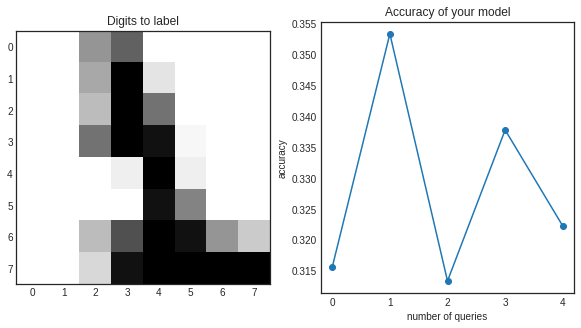

Which digit is this?


What is the digit? 1


In [26]:
accuracy_scores = [learner.score(X_test, y_test)]

for i in range(n_queries):
    display.clear_output(wait=True)
    query_idx, query_inst = learner.query(X_pool)
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Digits to label')
        plt.imshow(query_inst.reshape(8, 8))
        plt.subplot(1, 2, 2)
        plt.title('Accuracy of your model')
        plt.plot(range(i + 1), accuracy_scores)
        plt.scatter(range(i + 1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')

    print("Which digit is this?")
    y_new = np.array([int(input('What is the digit?'))], dtype=int)
    learner.teach(query_inst.reshape(1, -1), y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

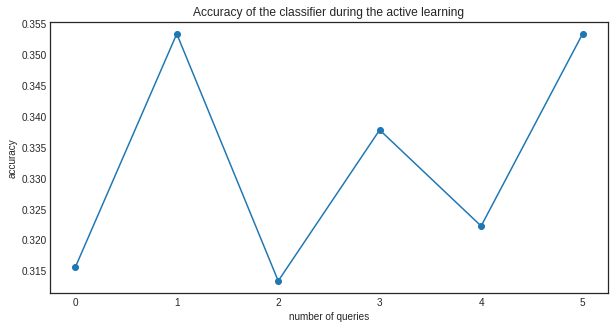

In [28]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries + 1), accuracy_scores)
    plt.scatter(range(n_queries + 1), accuracy_scores)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()